# Basic characterizations of UA Q4
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 3 # for UA Q4
res_index = 3 # for UA Q4
flux_index = 3 # for UA Q4
TLS_index = 0 # for TLS of interest

2024-02-05 14:34:51,828 - qm - INFO     - Starting session: 3311a57e-e53f-4fbc-a501-94d24c0a69e9


In [2]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [3]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [4]:
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [254]:
# this updates the octave settings, including rf_gain and rf_output_mode
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2024-01-19 11:46:41,929 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-19 11:46:41,944 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


In [5]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-02-05 14:35:30,603 - qm - INFO     - Octave "octave1" Health check passed, current temperature 57


INFO:qm:Octave "octave1" Health check passed, current temperature 57


2024-02-05 14:35:30,606 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-05 14:35:30,623 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-02-05 14:35:38,131 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.975 GHz, -50.000 MHz)
2024-02-05 14:35:50,862 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Time of flight

DC offset to add to I: 0.000008 V
DC offset to add to Q: 0.000215 V
TOF to add: 12.0 ns


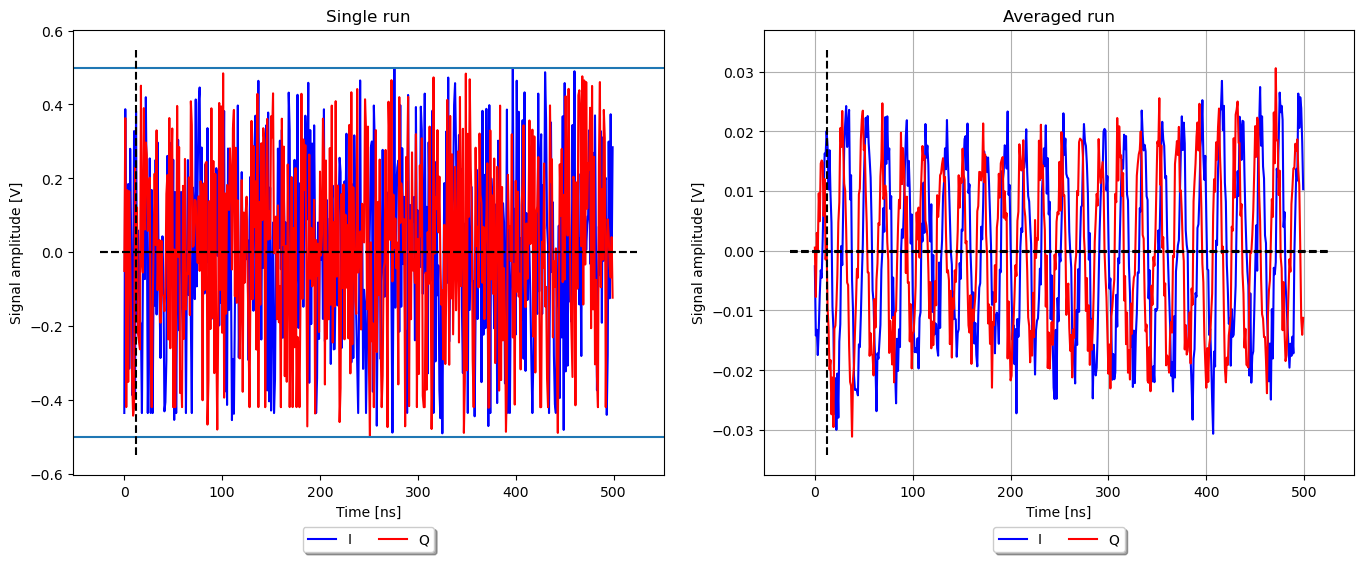

In [20]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 5E3, cd_time = 10E3, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [21]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += dc_offset_i.item()
machine.global_parameters.con1_downconversion_offset_Q += dc_offset_q.item()
machine.resonators[res_index].readout_pulse_amp = 0.35
machine.global_parameters.time_of_flight = 304
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.37s


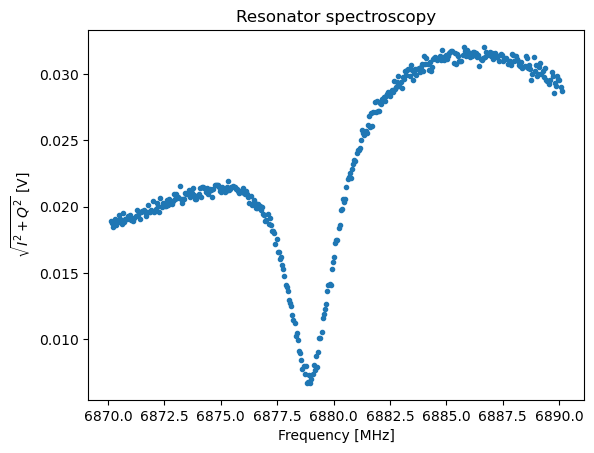

In [22]:
%matplotlib inline
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                           n_avg = 1E3, cd_time = 5E3, readout_state = 'e', simulate_flag = False, simulation_len = 1000)

resonator frequency: 6878.822 MHz


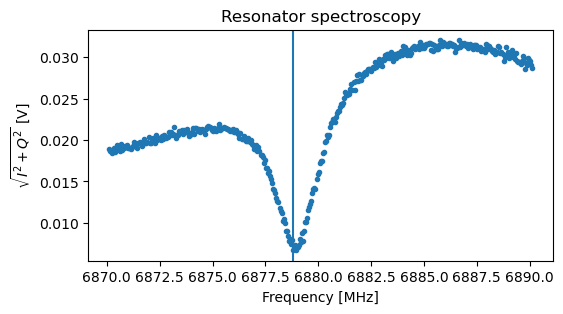

In [23]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine = Analysis.set_machine(machine)

## 2D RO resonator spectroscopy vs DC flux

In [24]:
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-6e6, 5e6, 0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib qt
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, 
                                plot_flag = False, n_avg = 2E3, cd_time = 10E3)

Progress: [##################################################] 100.0% (n=37/37)


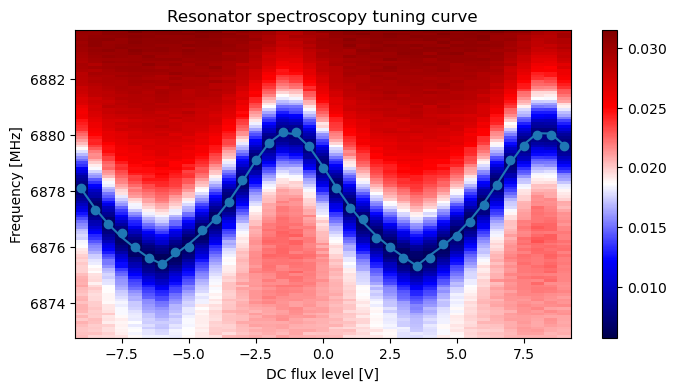

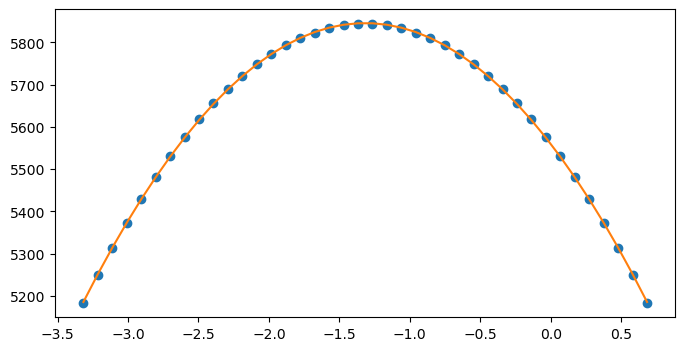

In [25]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = None)
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [26]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [27]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].DC_tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [28]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 20.73s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 20.77s
resonator frequency: 6880.126 MHz


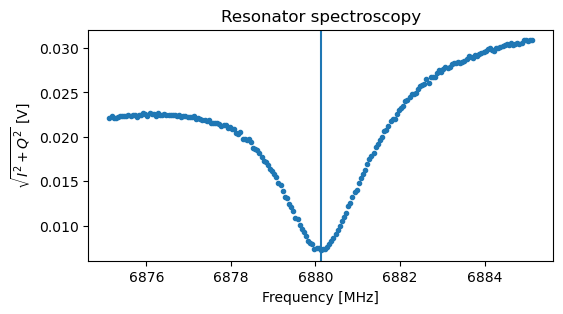

In [29]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 5E3, cd_time = 20E3, plot_flag = False, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [30]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

2024-02-05 14:42:19,753 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-05 14:42:19,762 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-02-05 14:42:26,752 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.975 GHz, -50.000 MHz)
2024-02-05 14:42:39,675 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [57]:
# for the DC flux
qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
# for the fast flux
# qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz
machine.qubits[qubit_index].lo = int(qubit_freq_est.tolist()) + 50E6
qubit_freq_sweep = int(qubit_freq_est) + np.arange(-30E6, 100E6 + 1, 0.5E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1.0, ff_amp = 0.0, n_avg = 10E3, cd_time = 20E3, plot_flag = False, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 54.88s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 54.94s


resonant frequency: 5920.417 MHz


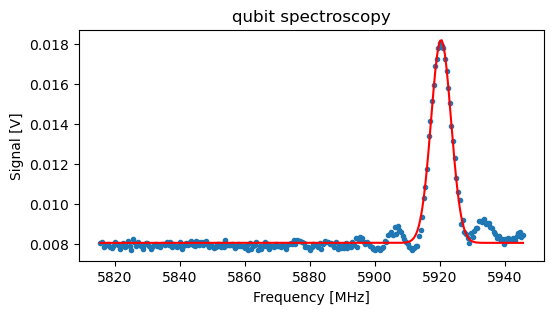

In [58]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq + 50E6
machine.qubits[qubit_index].f_tls[0] = qubit_freq + 0E6
machine = Analysis.set_machine(machine)

In [59]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag = True)

2024-02-05 14:54:11,900 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-05 14:54:11,909 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-02-05 14:54:18,986 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.970 GHz, -50.000 MHz)
2024-02-05 14:54:31,878 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Rabi

### time rabi

In [43]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 40 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, n_avg = 2E3, cd_time = 20E3, plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 1.44s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 1.48s


rabi_pi_pulse: 100.1 ns
half period: 103.99 ns


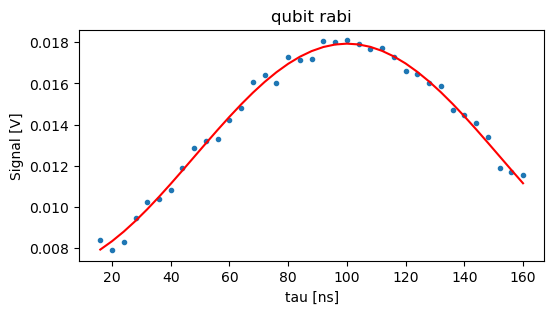

In [44]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [37]:
machine.qubits[qubit_index].pi_length[0] = 100
machine = Analysis.set_machine(machine)

### power rabi

In [40]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.3, 2, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 10E3, cd_time = 20E3, plot_flag = False, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 6.99s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 7.03s


rabi_pi_pulse_amp: 0.01828 V
half period: 0.0176838 V


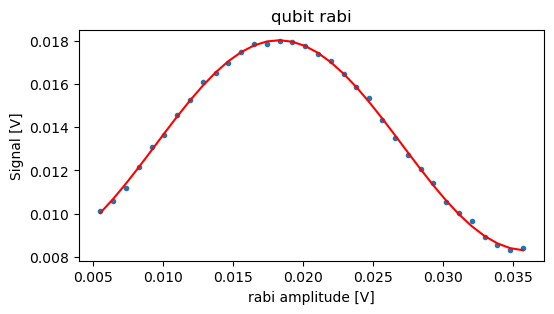

In [41]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [42]:
machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.tolist()
machine = Analysis.set_machine(machine)

## T1

In [48]:
%matplotlib qt
tau_sweep_abs = np.arange(100,30E3+1,400)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.qubit_T1(tau_sweep_abs, qubit_index, res_index, flux_index, 
                   n_avg = 10E3, cd_time = 30E3, simulate_flag = False, simulation_len = 15_000, plot_flag = False)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 34.10s


Qubit T1 [us]: 4.610949735346024


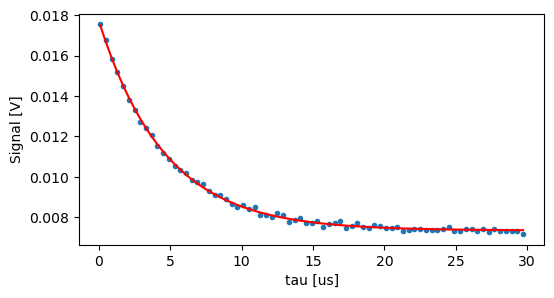

In [49]:
%matplotlib inline
q1_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")
machine.qubits[qubit_index].T1 = int(q1_T1.tolist())
machine = Analysis.set_machine(machine)

## Ramsey

In [73]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 4000 + 0.1, 10)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_amp = Experiment.exp1D.Ramsey.ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, 
          n_avg = 8E3, detuning = 2.5E6, cd_time = 20E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=8000/8000.0) --> elapsed time: 91.73s
Progress: [##################################################] 100.0% (n=8000/8000.0) --> elapsed time: 91.86s


Qubit T2* [ns]: 3333.981446071822
Detuning [MHz]: 0.5827798767103953
Exponent n: 0.9525935175508917


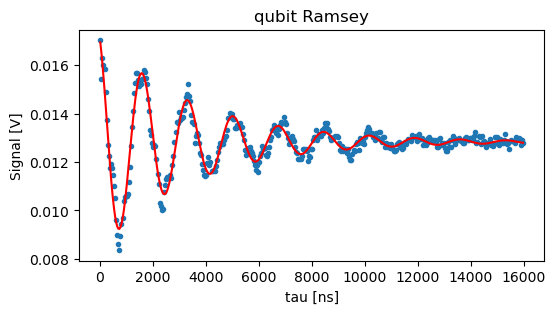

In [75]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_amp,plot_flag = True)
machine.qubits[qubit_index].T2 = int(q_T2star.tolist())
machine = Analysis.set_machine(machine)

## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-180E6, -100E6 + 1, 0.5E6) 
machine, ef_freq_sweep, sig_amp = Experiment.exp1D.Rabi.ef_freq(ef_freq_sweep, qubit_index, res_index, flux_index, 
                      pi_amp_rel = 1, pi_amp_rel_ef = 1.0, n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, 
                      simulate_flag = False, simulation_len = 4000)

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(x=ef_freq_sweep,y=sig_amp,method="gaussian")

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - int(ef_freq)
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_length[1] = 64
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 2.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.ef_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine,
                          simulate_flag = False, simulation_len = 1000)

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_amp[1] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## 2D qubit spectroscopy vs dc flux

In [76]:
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [90]:
machine = Analysis.get_machine()

Progress: [##################################################] 100.0% (n=49/49) --> elapsed time: 974.20s


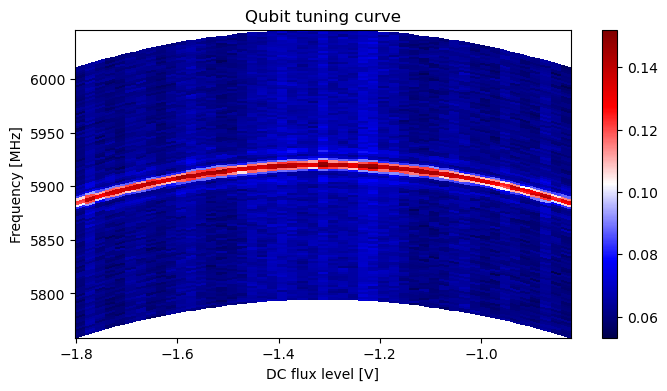

In [91]:
# try the experiment
%matplotlib inline
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.48,0.48+1E-4,0.02)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 2E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

In [92]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = False)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

sweet spot flux: -1.31306 V


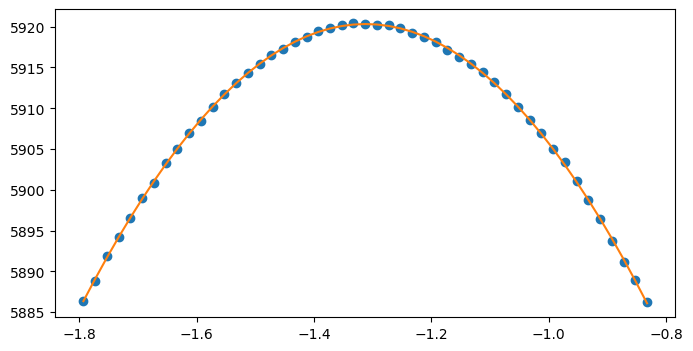

In [93]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

## 2D qubit spectroscopy vs fast flux

In [94]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, to find the initial fast flux tuning curve

2024-02-06 09:20:06,743 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-06 09:20:06,757 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.670 GHz, 250.000 MHz)
2024-02-06 09:20:11,967 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-02-06 09:20:49,428 - qm - INFO     - Performing health check.1% (n=4/7) --> elapsed time: 42.64s


INFO:qm.api.frontend_api:Performing health check


2024-02-06 09:20:49,439 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.481 GHz, 250.000 MHz)
2024-02-06 09:20:54,433 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-02-06 09:21:17,847 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-06 09:21:17,858 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.359 GHz, 250.000 MHz)
2024-02-06 09:21:22,825 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-02-06 09:21:46,245 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-06 09:21:46,255 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.236 GHz, 250.000 MHz)
2024-02-06 09:21:51,210 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=7/7) --> elapsed time: 126.95s
2024-02-06 09:22:13,745 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-06 09:22:13,756 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.135 GHz, 250.000 MHz)
2024-02-06 09:22:18,836 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


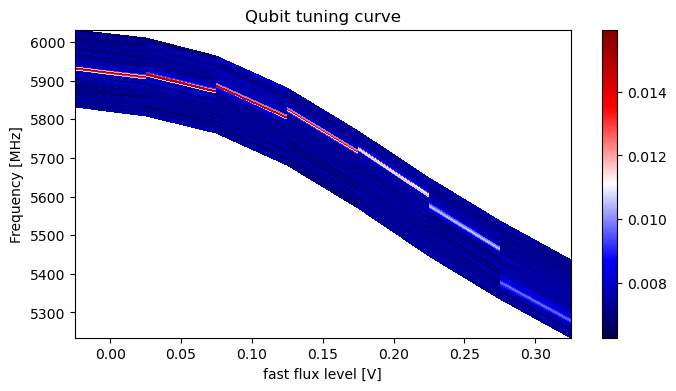

In [100]:
# try the experiment
%matplotlib inline
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.3+1E-4,0.05)
qubit_if_sweep = np.arange(-100E6, 100E6 + 1, 1E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = 7.8, machine = machine, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

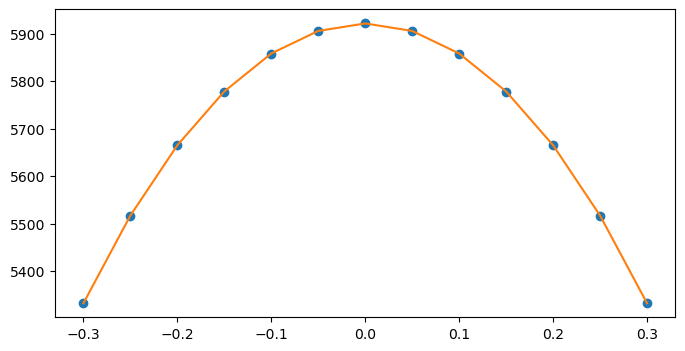

In [101]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

-------------------------------------some fast flux > 0.5V, removed from experiment run
2024-02-06 09:33:24,805 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-06 09:33:24,818 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.621 GHz, 200.000 MHz)
2024-02-06 09:33:30,630 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.08s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.23s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.03s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.19s
2024-02-06 09:40:39,882 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-06 09:40:39,890 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.421 GHz, 200.000 MHz)
2024-02-06 09:40:45,808 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.10s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.25s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.02s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.19s
2024-02-06 09:47:54,307 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-06 09:47:54,321 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (4.821 GHz, 200.000 MHz)
2024-02-06 09:48:00,009 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.03s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.19s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.06s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.22s
2024-02-06 09:55:08,312 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-06 09:55:08,326 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (4.621 GHz, 200.000 MHz)
2024-02-06 09:55:14,241 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.04s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.19s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.03s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.19s
2024-02-06 10:02:23,375 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-06 10:02:23,390 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (4.021 GHz, 200.000 MHz)
2024-02-06 10:02:29,327 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 137.04s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 137.19s
2024-02-06 10:05:05,056 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-06 10:05:05,070 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (3.821 GHz, 200.000 MHz)
2024-02-06 10:05:10,511 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


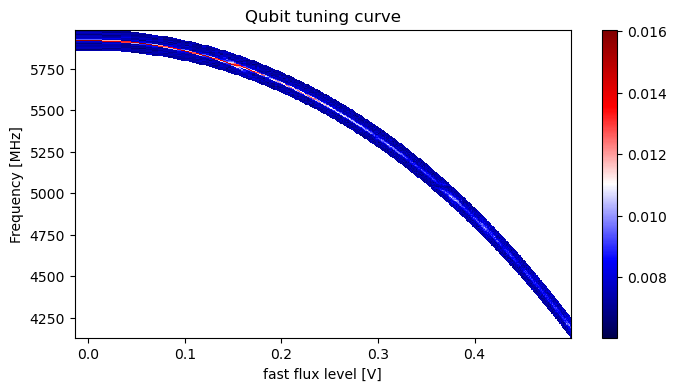

In [106]:
%matplotlib inline
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4E9, -5E6)
#qubit_freq_sweep = np.arange(5.85E9,4.5E9,-50E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

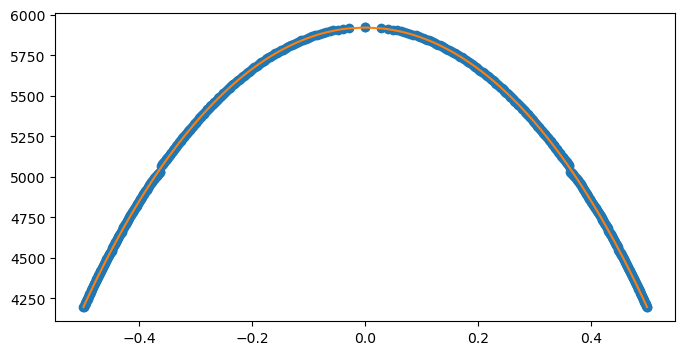

In [108]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

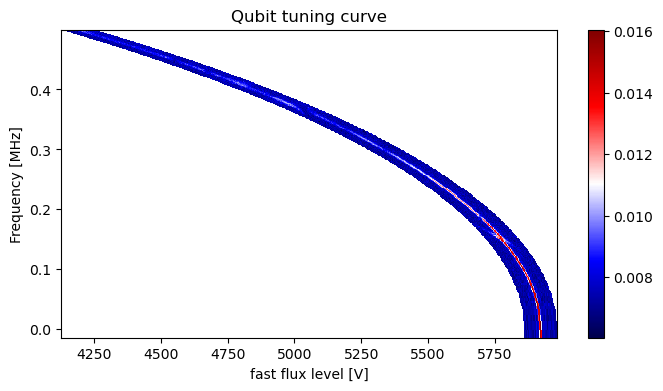

In [110]:
%matplotlib inline
fig = plt.figure()
plt.rcParams['figure.figsize'] = [8, 4]
plt.pcolormesh(qubit_freq_sweep / u.MHz, ff_sweep_abs, sig_amp_qubit, cmap="seismic")
plt.title("Qubit tuning curve")
plt.xlabel("fast flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()

# TLS experiments

## TLS SWAP spectroscopy

In [111]:
# machine.qubits[qubit_index].f_01 = round(np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0).tolist()*1E6) + 0E6
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] +0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)

In [112]:
machine = Analysis.get_machine()
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True, machine = machine)

2024-02-06 10:08:32,455 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-06 10:08:32,470 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-02-06 10:08:39,413 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.970 GHz, -50.000 MHz)
2024-02-06 10:08:52,255 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


### coarse, no baking

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 332.02s


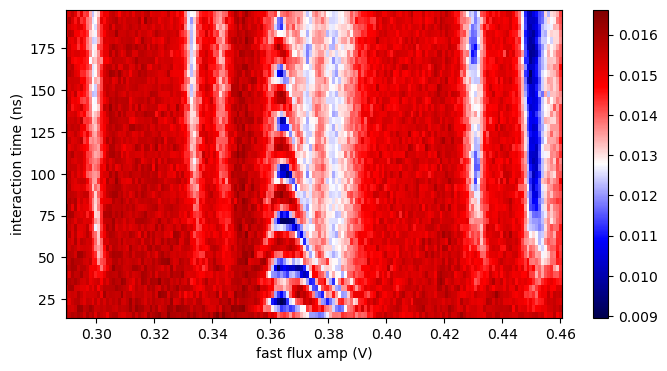

In [113]:
%matplotlib inline
tau_sweep_abs = np.arange(16,200,4)
ff_sweep_abs = np.arange(0.29,0.46,0.001)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_coarse(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 2E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

### fine, with baking

In [114]:
%matplotlib qt
tau_sweep_abs = np.arange(4,120,1)
ff_sweep_abs = np.arange(0.355,0.39,0.0005)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_fine(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 4E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1341.10s
Execution stopped by user!


In [115]:
machine.flux_lines[flux_index].iswap.length[TLS_index] = 26
machine.flux_lines[flux_index].iswap.level[TLS_index] = 0.362
machine = Analysis.set_machine(machine)

In [50]:
machine.flux_lines[flux_index].iswap.length.append(22)
machine.flux_lines[flux_index].iswap.level.append(0.448)
machine = Analysis.set_machine(machine)

### estiguess of the TLS freq., based on SWAP flux

In [116]:
machine = Analysis.get_machine()

In [118]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
machine.qubits[qubit_index].f_tls[1] =(np.floor(freq_tls[0]*1E6))
machine = Analysis.set_machine(machine)

In [210]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
for f_tmp in freq_tls:
    machine.qubits[qubit_index].f_tls.append(np.floor(f_tmp*1E6))
machine = Analysis.set_machine(machine)

## TLS T1

In [119]:
TLS_index = 0

In [127]:
%matplotlib qt
tau_sweep_abs = np.arange(200,20000E3+1,50E4)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 20000E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Execution stopped by user!                                   ] 28.6% (n=1428/5000.0) --> elapsed time: 1701.17s


Qubit T1 [us]: 3500.7876647309104


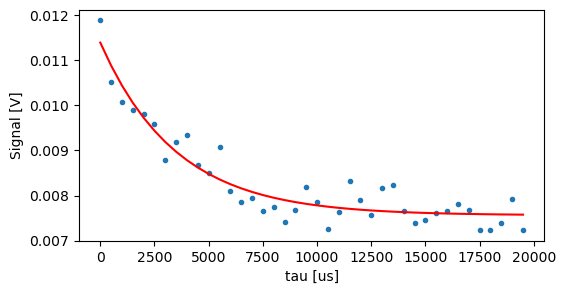

In [129]:
%matplotlib inline
tls_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

## TLS drive

### TLS spectroscopy

In [130]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01

In [131]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
TLS_freq_est = np.round(TLS_freq_est[0] * 1E6)
if len(machine.qubits[qubit_index].f_tls) < TLS_index + 2: # need to increase size
    machine.qubits[qubit_index].f_tls.append(int(TLS_freq_est.tolist()) + 0E6)
    machine.qubits[qubit_index].lo.append(int(TLS_freq_est.tolist()) - 200E6)
else: # just update the value
    machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist()))
    machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 200E6

In [132]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1] + 0E6
machine = Analysis.set_machine(machine)

In [157]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2024-02-06 14:45:21,593 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-06 14:45:21,604 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-02-06 14:45:28,698 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (4.844 GHz, 200.000 MHz)
2024-02-06 14:45:40,665 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [158]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index+1] + np.arange(-30E6,30E6+1,1E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 10E3, cd_time_qubit = 20E3, cd_time_TLS = 1500E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 927.65s


resonant frequency: 5043.886 MHz


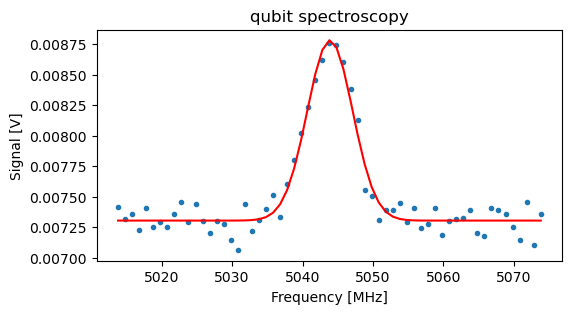

In [160]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
# update TLS freq
machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 200E6
# save the parameters
machine = Analysis.set_machine(machine)

### TLS rabi

In [ ]:
machine.flux_lines[flux_index].iswap.level[TLS_index] = 0.219
machine = Analysis.set_machine(machine)

In [182]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 500 + 0.1, 5)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 1500E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 760.42s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 760.51s


T2rabi: 467.2 ns
rabi_pi_pulse: 319.4 ns
half period: 349.95 ns


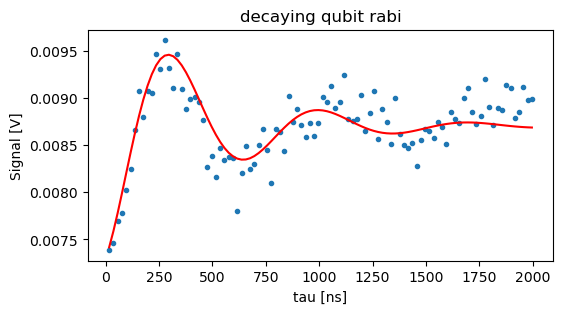

In [184]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,method = "decaying_time_rabi", plot_flag = True)

In [172]:
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_length_tls.append(100)
else: # just update the value
    machine.qubits[qubit_index].pi_length_tls[TLS_index] = 100
    
machine = Analysis.set_machine(machine)

### Power Rabi

In [177]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.3, 2, 0.01) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, TLS_index = TLS_index,  
                                          n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 1500E3, plot_flag = False, machine = machine)

some abs amps > 0.5, removed from experiment run
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 722.20s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 722.25s


rabi_pi_pulse_amp: 0.62444 V
half period: 0.5120000 V


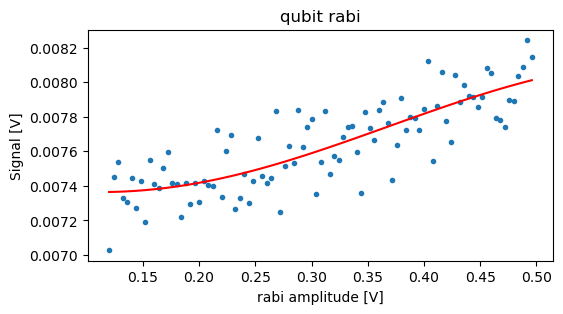

In [178]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [181]:
pi_pulse_amp = 0.5
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_amp_tls.append(pi_pulse_amp)
else: # just update the value
    machine.qubits[qubit_index].pi_amp_tls[TLS_index] = pi_pulse_amp
machine = Analysis.set_machine(machine)